**```Integrantes:```**

- Bernardo do Nascimento Nunes - 2021031777
- Indra Matsiendra Cardoso Dias Ribeiro - 2021031807


In [21]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\berna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [22]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\berna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
!pip install pandas


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\berna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math

### **Envoltória Convexa**

In [25]:
def polar_angle(p1, p2): # Esta função calcula o angulo polar
  return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

def orientation(p, q, r): # Esta função calcula se o segmento pq está em sentido horário ou anti-hotário em relação ao segmento pr
  val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
  if val == 0:
    return 0  # Colinear
  return 1 if val > 0 else 2  # Horário ou anti-horário

def graham_scan(points): # Algoritmo para gerar a envoltória convexa
  n = len(points)
  pivot = min(points, key=lambda p: (p[1], p[0]))
  sorted_points = sorted(points, key=lambda p: (polar_angle(pivot, p), -p[1], p[0]))
  hull = [sorted_points[0], sorted_points[1]]
  for i in range(2, n):
    while len(hull) > 1 and orientation(hull[-2], hull[-1], sorted_points[i]) != 2:
      hull.pop()
    hull.append(sorted_points[i])
  return hull

### **Varredura Linear**

In [26]:
def generate_hull_segments(hull):
  segments = []
  for i in range(1, len(hull)):
    segments.append([hull[i-1], hull[i]])
  return segments

def on_segment(p, q, r): # Verifica se o ponto q está no segmento formado por p e r.
  return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and
          q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

def do_intersect(p1, q1, p2, q2): # Verifica se os segmentos de linha (p1, q1) e (p2, q2) se cruzam.
  o1 = orientation(p1, q1, p2)
  o2 = orientation(p1, q1, q2)
  o3 = orientation(p2, q2, p1)
  o4 = orientation(p2, q2, q1)

  if o1 != o2 and o3 != o4:
    return True

  if o1 == 0 and on_segment(p1, p2, q1):
    return True
  if o2 == 0 and on_segment(p1, q2, q1):
    return True
  if o3 == 0 and on_segment(p2, p1, q2):
    return True
  if o4 == 0 and on_segment(p2, q1, q2):
    return True

  return False


def has_intersection(hull_1_segments, hull_2_segments): # Verifica se há interseção entre duas envoltórias convexas. Essa é a versão não otimizada do algoritmo de varredura linear O(n²).
  for seg1 in hull_1_segments:
    for  seg2 in hull_2_segments:
      if do_intersect(seg1[0], seg1[1], seg2[0], seg2[1]):
        return True
  return False

### **Modelo de classificação e Reta que separa as envoltórias**

In [27]:
'''
O modelo de classificação desenvolvido neste trabalho é constituído por essas 5 variáveis globais abaixo, que representam
as envoltórias convexas de cada classe e os pontos mais próximos das duas envoltórias e qual a classe predominante.
Ao fazer a classificação de um ponto p qualquer o modelo leva em conta a reta perpendicular entre os pontos mais próximos
das duas envoltórias, ou seja, se p está mais perto de p1 ele pertence à classe 1, se está mais perto de p2 pertence à
classe 2 e se está em cima da reta optamos por classificá-lo como parte da classe predominante(aquela com mais ocorrências).
'''
model_p1 = np.array([])
model_p2 = np.array([])
model_hull_1 = np.array([])
model_hull_2 = np.array([])
default_class = 0

def distance(p1, p2): # Distância entre dois pontos
  return ((p1[0] - p2[0]) * (p1[0] - p2[0]) +
          (p1[1] - p2[1]) * (p1[1] - p2[1]))

def closest_points(hull_1, hull_2): # Pontos mais próximos entre as duas envoltórias
  min1 = hull_1[0]
  min2 = hull_2[0]
  dist = distance(min1, min2)
  for p1 in hull_1:
    for p2 in hull_2:
      if distance(p1, p2) < dist:
        min1 = p1
        min2 = p2
        dist = distance(p1, p2)
  return min1, min2


def get_model_line_equation(): # Retorna o coeficiente linear e angular da reta
  '''
  y=ax+b
  a = coeficiente angular
  b = coeficiente linear
  '''
  m_point = (model_p1 + model_p2) / 2
  original_angular_coefficient = (model_p2[1] - model_p1[1]) / (model_p2[0] - model_p1[0])
  perpendicular_angular_coefficient = -1 / original_angular_coefficient
  perpendicular_linear_coefficient = m_point[1] - perpendicular_angular_coefficient * m_point[0]
  return (perpendicular_angular_coefficient, perpendicular_linear_coefficient)

def model_fit(X, y, classes):
  global model_p1
  global model_p2
  global model_hull_1
  global model_hull_2
  global default_class

  mask_1 = (y == classes[0])
  mask_2 = (y == classes[1])
  X_1 = X[mask_1]
  y_1 = y[mask_1]
  X_2 = X[mask_2]
  y_2 = y[mask_2]
  default_class = max(np.sum(mask_1), np.sum(mask_2))

  model_hull_1 = graham_scan(X_1)
  model_hull_2 = graham_scan(X_2)

  model_p1, model_p2 = closest_points(model_hull_1, model_hull_2)

  hull_1_segments = generate_hull_segments(model_hull_1)
  hull_2_segments = generate_hull_segments(model_hull_2)
  if has_intersection(hull_1_segments, hull_2_segments): # Quando duas envoltórias se interceptam
    raise Exception("Watch out! There is an intersection between classes, the model won't work as expected!")

def model_predict(points, classes):
  # Para cada ponto de entrada, calcula a distância até os dois pontos mais próximos
  # das envoltórias e atribui o rótulo da classe com o ponto mais próximo.
  '''
  p1 é o ponto da envoltoria convexa da classes[0]
  p2 é o ponto da envoltoria convexa da classes[1]
  '''
  y = []
  for p in points:
    d1 = distance(model_p1, p)
    d2 = distance(model_p2, p)
    if d1 < d2:
      y.append(classes[0])
    elif d2 < d1:
      y.append(classes[1])
    else:
      y.append(default_class)
  return np.array(y)

### **Métricas de avaliação**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(y_test, y_pred): # Função para avaliar as metricas
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')

  print("Acurácia:", accuracy)
  print("Precisão:", precision)
  print("Revocação:", recall)
  print("F1:", f1)

### **Funções para exibição dos gráficos**

In [29]:
def plot_dataset_points(X, y, class_numbers, class_names, title, colors=None):
  lw = 2
  if colors:
    for c, i, class_name in zip(colors, class_numbers, class_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=c, alpha=0.8, lw=lw, label=class_name)
  else:
    for i, class_name in zip(class_numbers, class_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], alpha=0.8, lw=lw, label=class_name)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)
  plt.show()

def plot_dataset_points_and_model_hull(X, y, class_numbers, class_names, title, colors=None):
  lw = 2
  #plotando os pontos de cada classe com uma cor
  if colors:
    for c, i, class_name in zip(colors, class_numbers, class_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=c, alpha=0.8, lw=lw, label=class_name)
  else:
    for i, class_name in zip(class_numbers, class_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], alpha=0.8, lw=lw, label=class_name)

  #linha que liga os pontos mais proximos das duas envoltórias para as quais o modelo foi treinado da última vez
  [model_p1[0], model_p2[0]]
  plt.plot([model_p1[0], model_p2[0]], [model_p1[1], model_p2[1]], marker='o', linestyle='-', color='mediumturquoise', label='Hull closest points')

  #ligando plotando as envoltórias convexas das duas classes do modelo
  x_graf = [p[0] for p in model_hull_1] + [model_hull_1[0][0]]
  y_graf = [p[1] for p in model_hull_1] + [model_hull_1[0][1]]
  plt.plot(x_graf, y_graf, linestyle='-', color='mediumseagreen', label='Convex hull for class 1')
  x_graf = [p[0] for p in model_hull_2] + [model_hull_2[0][0]]
  y_graf = [p[1] for p in model_hull_2] + [model_hull_2[0][1]]
  plt.plot(x_graf, y_graf, linestyle='-', color='steelblue', label='Convex hull for class 2')


  #equação da reta do modelo linear
  a, b = get_model_line_equation()
  x_graf = [p[0] for p in model_hull_1] + [p[0] for p in model_hull_2]
  p1 = [max(x_graf), a*max(x_graf)+b]
  p2 = [min(x_graf), a*min(x_graf)+b]

  y_graf = [p[1] for p in model_hull_1] + [p[1] for p in model_hull_2]
  p3 = [(max(y_graf)-b)/a, max(y_graf)]
  p4 = [(min(y_graf)-b)/a, min(y_graf)]

  if distance(p1, p2) < distance(p3, p4):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linestyle='-', color='navy', label='Model line equation')
  else:
    plt.plot([p3[0], p4[0]], [p3[1], p4[1]], linestyle='-', color='navy', label='Model line equation')

  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)
  plt.show()

### **Datasets e Relatório**

In [30]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#### **1) Iris dataset**

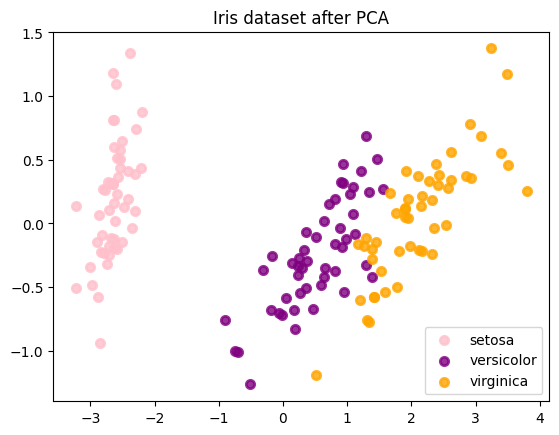

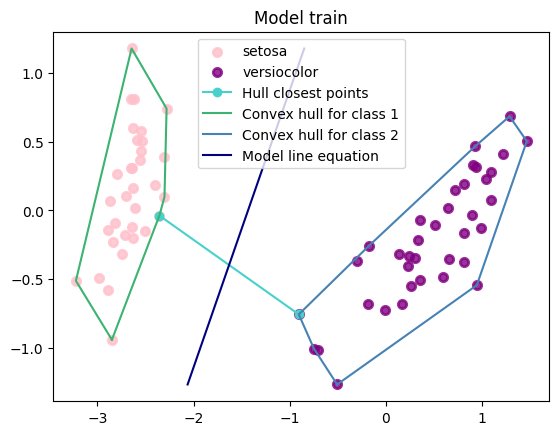

Acurácia: 1.0
Precisão: 1.0
Revocação: 1.0
F1: 1.0


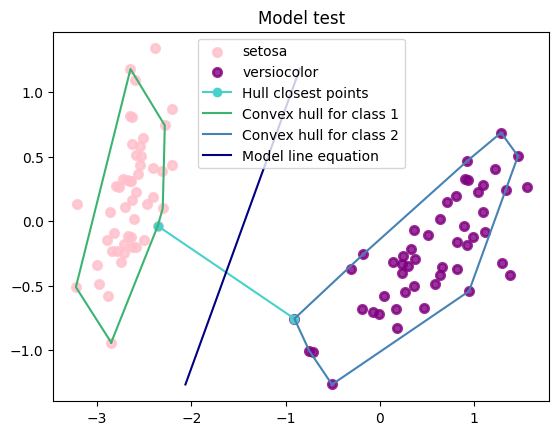

In [31]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

# aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, range(len(iris.target_names)), iris.target_names, 'Iris dataset after PCA', colors=['pink', 'purple', 'orange'])

# selecionando as classes setosa e versiocolor
class_numbers = [0, 1]
class_names = ['setosa', 'versiocolor']
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['pink', 'purple'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo levando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['pink', 'purple'])

#### **2) Wine dataset**

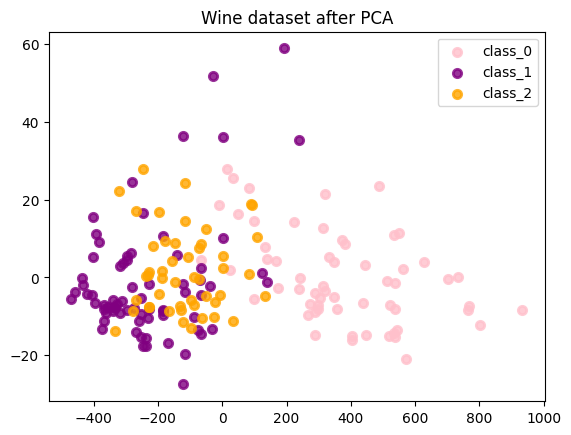

Watch out! There is an intersection between classes, the model won't work as expected!


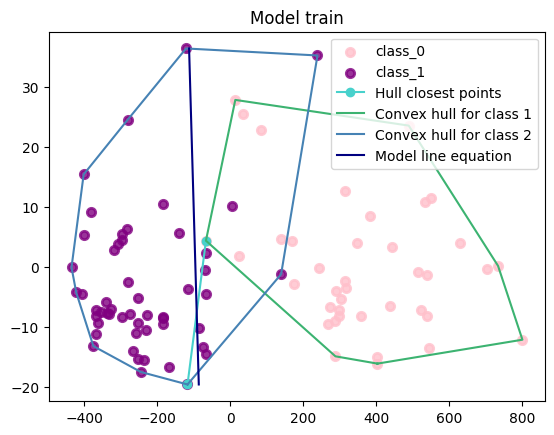

Acurácia: 0.8461538461538461
Precisão: 0.8816568047337279
Revocação: 0.8461538461538461
F1: 0.8417642140468229


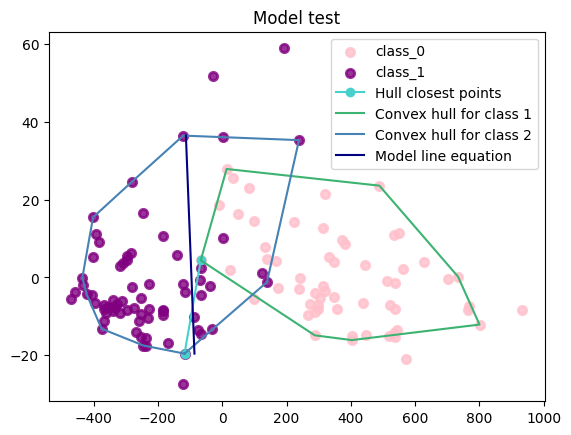

In [32]:
wine = datasets.load_wine()

X = wine.data
y = wine.target

# aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, range(len(wine.target_names)), wine.target_names, 'Wine dataset after PCA', colors=['pink', 'purple', 'orange'])

# selecionando as classes class_0 e class_1
class_numbers = [0,1]
class_names = ['class_0', 'class_1']
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

 #dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['pink', 'purple'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo levando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['pink', 'purple'])


#### **3) Cancer dataset**

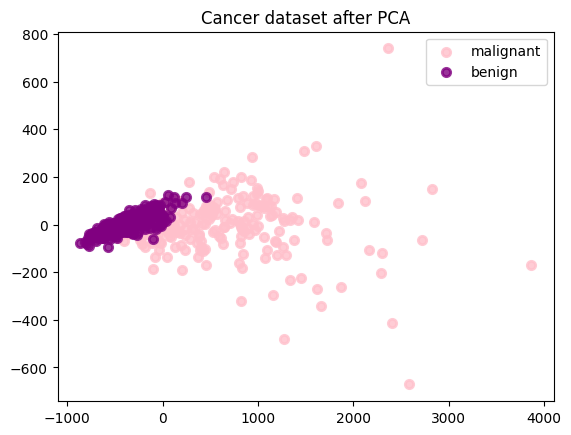

Watch out! There is an intersection between classes, the model won't work as expected!


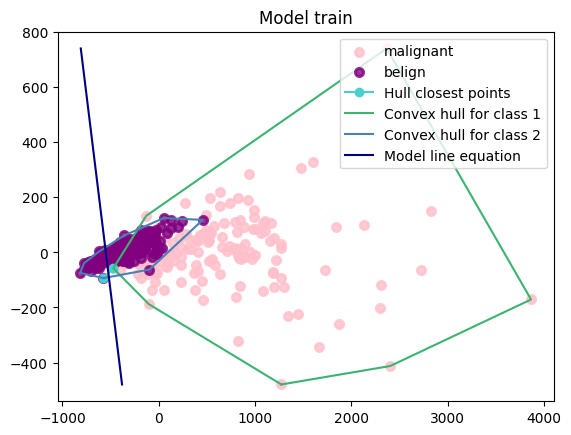

Acurácia: 0.52046783625731
Precisão: 0.7916515426497278
Revocação: 0.52046783625731
F1: 0.4682684754365822


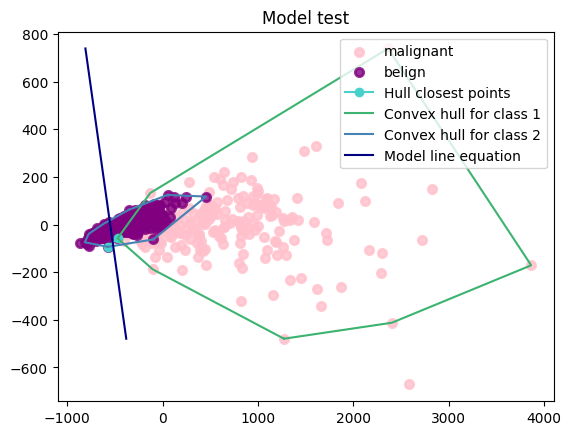

In [33]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, range(len(cancer.target_names)), cancer.target_names, 'Cancer dataset after PCA', colors=['pink', 'purple', 'orange'])

# selecionando as classes malignant e belign
class_numbers = [0,1]
class_names = ['malignant', 'belign']
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

#treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['pink', 'purple'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo levando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['pink', 'purple'])


#### **4) Water Potability dataset**

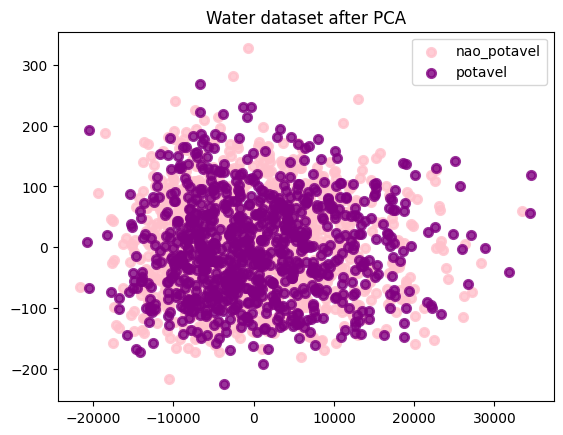

Watch out! There is an intersection between classes, the model won't work as expected!


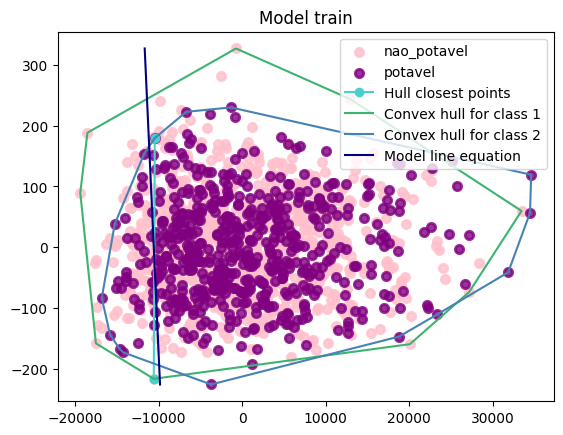

Acurácia: 0.43211920529801323
Precisão: 0.519220244665195
Revocação: 0.43211920529801323
F1: 0.33964281428077003


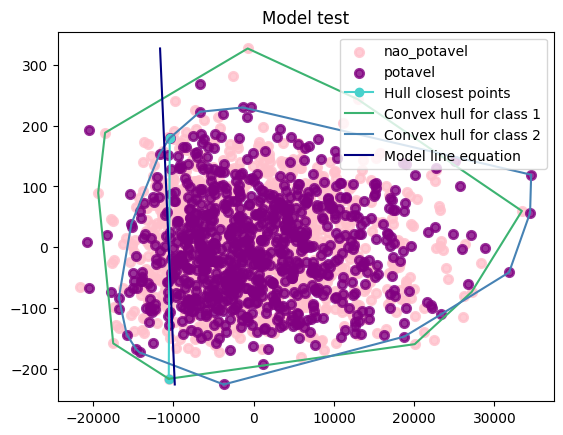

In [34]:
import pandas as pd
water = pd.read_csv('https://raw.githubusercontent.com/Bernardonasc/Geometria-Computacional/main/datasets/water_potability.csv')
water = water.dropna()

y = water.Potability

# aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = water.drop('Potability', axis=1)
X = pca.fit_transform(X)

class_names = ['nao_potavel', 'potavel']
class_numbers = [0,1]

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, class_numbers, class_names, 'Water dataset after PCA', colors=['pink', 'purple'])

# selecionando as classes potavel e nao_potavel
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

#treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)
#modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['pink', 'purple'])

#avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

#desempenho do modelo lebando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['pink', 'purple'])


### **5) Diabetes dataset**


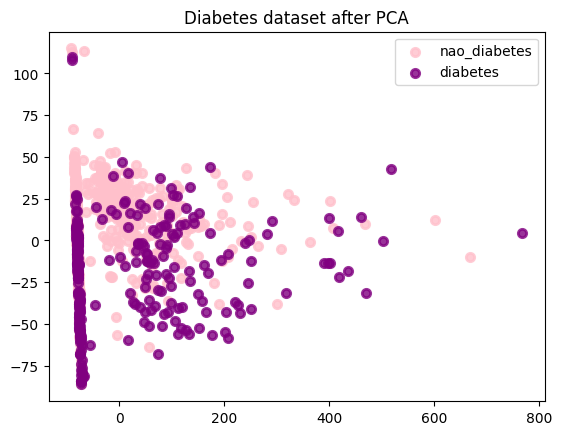

Watch out! There is an intersection between classes, the model won't work as expected!


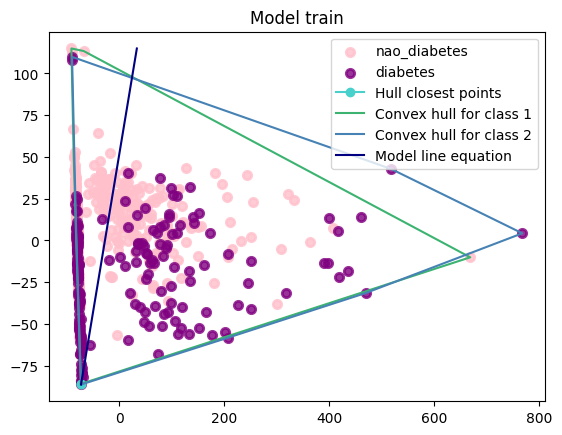

Acurácia: 0.5930735930735931
Precisão: 0.6076773815278663
Revocação: 0.5930735930735931
F1: 0.5988495332520994


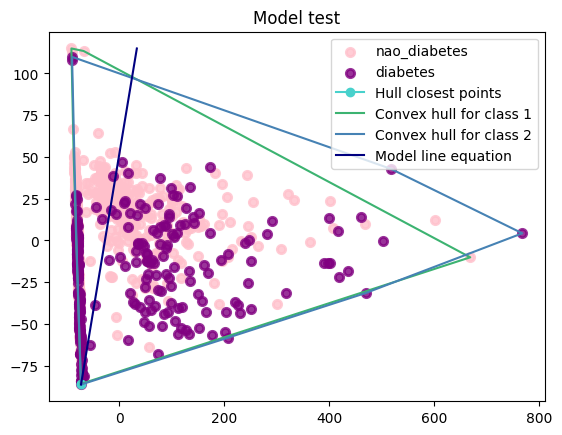

In [35]:
diabetes = pd.read_csv('https://raw.githubusercontent.com/Bernardonasc/Geometria-Computacional/main/datasets/diabetes.csv')
diabetes = diabetes.dropna()

y = diabetes.Outcome

#aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = diabetes.drop('Outcome', axis=1)
X = pca.fit_transform(X)

class_names = ['nao_diabetes', 'diabetes']
class_numbers = [0,1]

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, class_numbers, class_names, 'Diabetes dataset after PCA', colors=['pink', 'purple'])

# selecionando as classes diabetes e nao_diabetes
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# ividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['pink', 'purple'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo levando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['pink', 'purple'])


### **6) Digits**

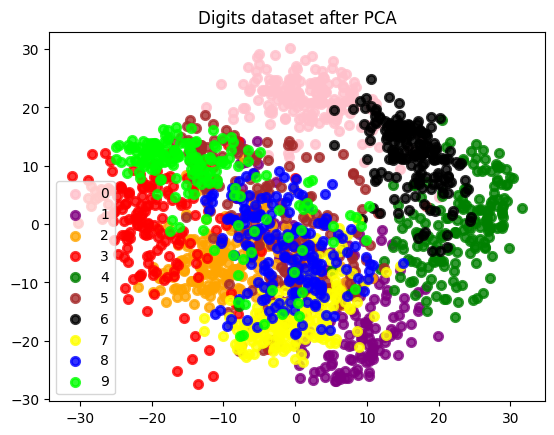

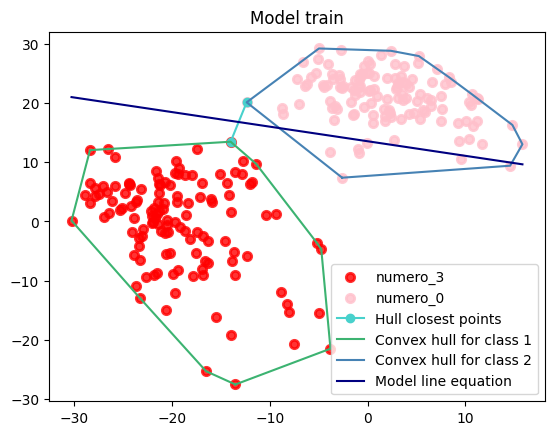

Acurácia: 0.9908256880733946
Precisão: 0.9909866409142122
Revocação: 0.9908256880733946
F1: 0.9908225951743042


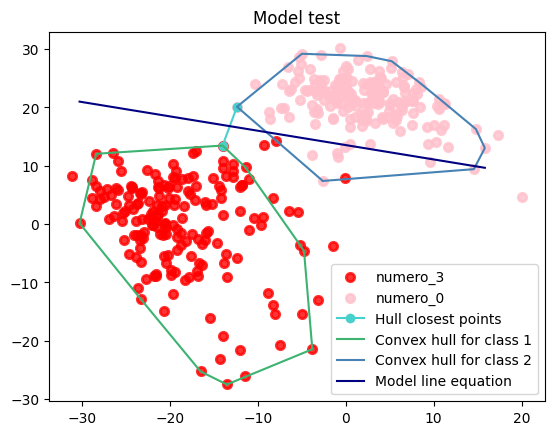

Watch out! There is an intersection between classes, the model won't work as expected!


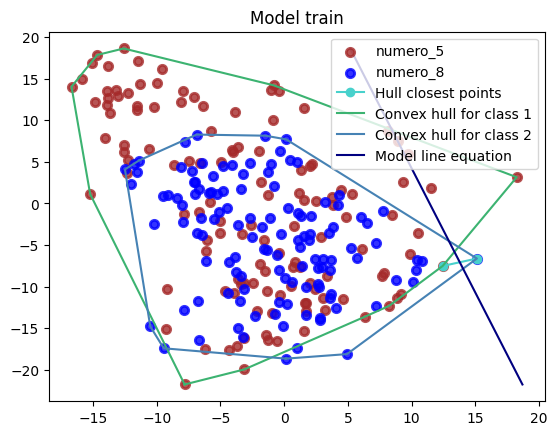

C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia: 0.514018691588785
Precisão: 0.2642152153026465
Revocação: 0.514018691588785
F1: 0.34902503749855773


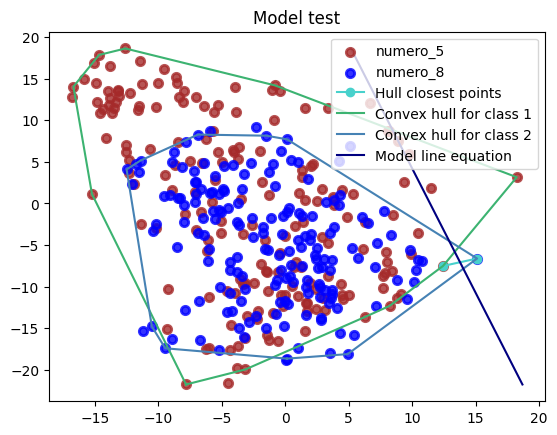

In [36]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

# aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, range(len(digits.target_names)), digits.target_names, 'Digits dataset after PCA', colors=['pink', 'purple', 'orange', 'red', 'green', 'brown', 'black', 'yellow', 'blue', 'lime'])

# selecionando as classes 0 e 3
class_numbers = [3,0]
class_names = ['numero_3', 'numero_0']
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['red', 'pink'])


# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo lebando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['red', 'pink'])

# selecionando as classes 5 e 8
class_numbers = [5,8]
class_names = ['numero_5', 'numero_8']
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['brown', 'blue'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo levando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['brown', 'blue'])



### **7) Covertype**


C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


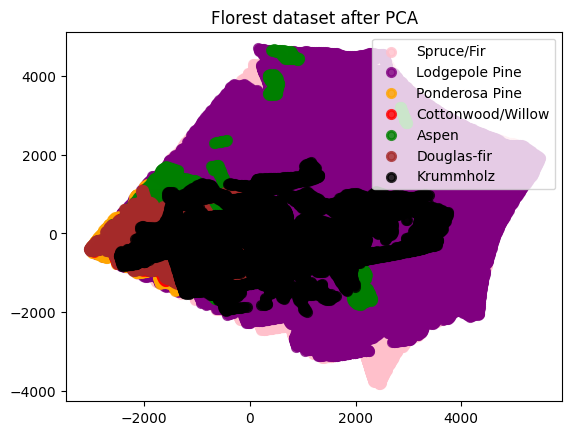

Watch out! There is an intersection between classes, the model won't work as expected!


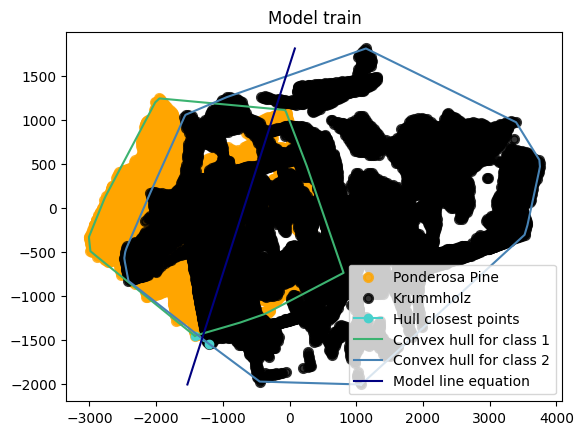

Acurácia: 0.8473431668740004
Precisão: 0.8458668234011368
Revocação: 0.8473431668740004
F1: 0.8456079392656397


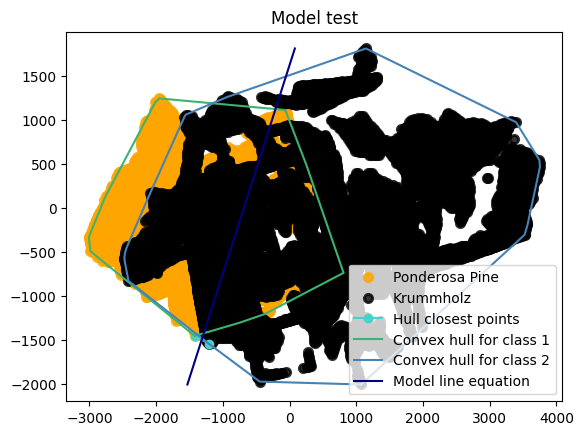

In [37]:
florest = datasets.fetch_covtype(as_frame = 1)

X = florest.data
y = florest.target

# aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = pca.fit_transform(X)

class_numbers = [1,2,3,4,5,6,7]
class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

# plotando viSualização do conjunto de dados no geral
plot_dataset_points(X, y, class_numbers, class_names, 'Florest dataset after PCA', colors=['pink', 'purple', 'orange', 'red', 'green', 'brown', 'black'])

# selecionando as classes Ponderosa Pine E Krummholz
class_numbers = [3,7]
class_names = ['Ponderosa Pine','Krummholz']
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.1, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['orange', 'black'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo leVando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['orange', 'black'])


### **8) Wine Quality**

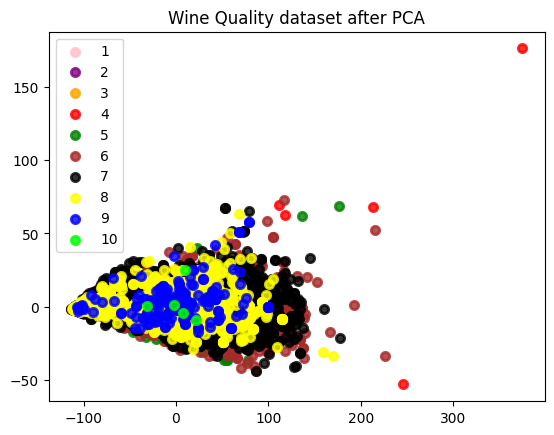

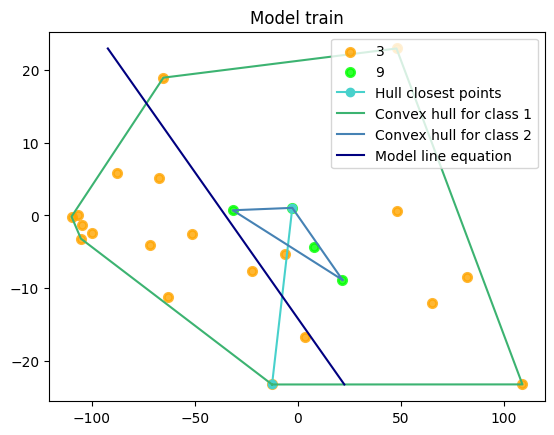

Acurácia: 0.45454545454545453
Precisão: 0.922077922077922
Revocação: 0.45454545454545453
F1: 0.5422077922077922


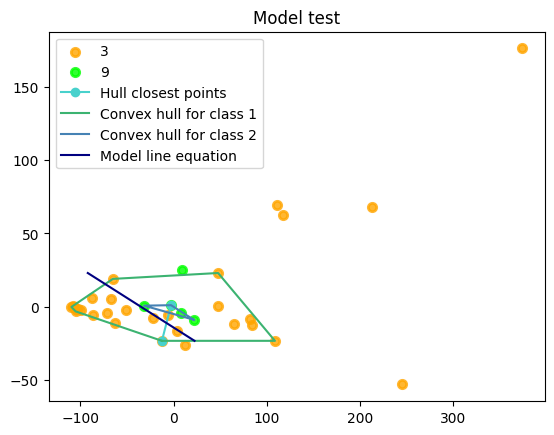

In [38]:
wine_quality = pd.read_csv('https://raw.githubusercontent.com/Bernardonasc/Geometria-Computacional/main/datasets/winequality.csv')
wine_quality = wine_quality.dropna()
wine_quality = wine_quality.drop('type', axis=1) # trabalhando apenas com a classificacao e nao o tipo do vinho

class_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # faixas de valores desejadas
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']  # rótulos das classes

y = wine_quality.quality
X = wine_quality.drop('quality', axis=1)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, range(len(class_numbers)), class_names, 'Wine Quality dataset after PCA', colors=['pink', 'purple', 'orange', 'red', 'green', 'brown', 'black', 'yellow', 'blue', 'lime'])

# selecionando vinhos com qualidade 3 e 9
class_numbers = [3,9]
class_names = [3,9]
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['orange', 'lime'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo levando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['orange', 'lime'])


### **9) Face dataset**

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\berna\scikit_learn_data


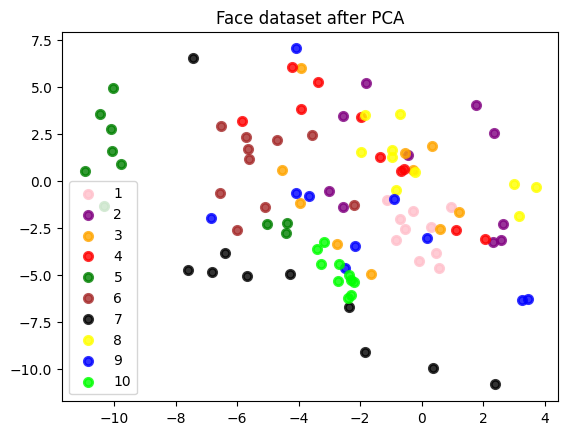

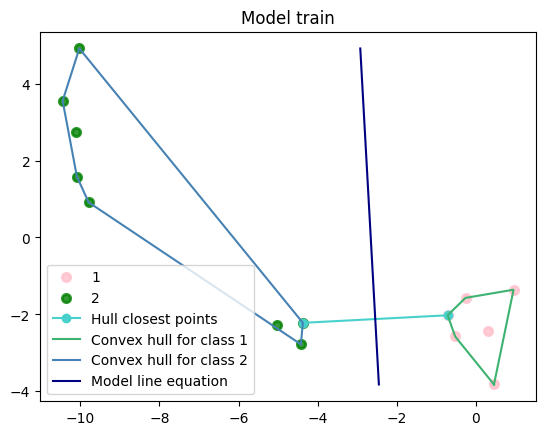

Acurácia: 1.0
Precisão: 1.0
Revocação: 1.0
F1: 1.0


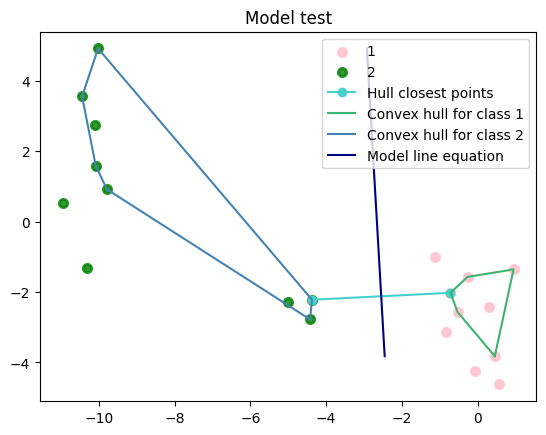

In [39]:
face = datasets.fetch_olivetti_faces()

X = face.data
y = face.target

#aplicando o PCA para pegar apenas 2 features
pca = PCA(n_components=2)
X = pca.fit_transform(X)

class_numbers = [1,2,3,4,5,6,7,8,9,10] # Selecionando apenas 10 rostos de 40
class_names = ['1', '2', '3', '4', '5', '6', '7', '8','9','10']

# plotando visualização do conjunto de dados no geral
plot_dataset_points(X, y, class_numbers, class_names, 'Face dataset after PCA', colors=['pink', 'purple', 'orange', 'red', 'green', 'brown', 'black', 'yellow', 'blue', 'lime'])

# selecionando os rostos com id 1 e 5
class_numbers = [1,5]
mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

# dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)

# modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['pink', 'green'])

# avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

# desempenho do modelo levando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['pink', 'green'])


### **10) Titanic dataset**

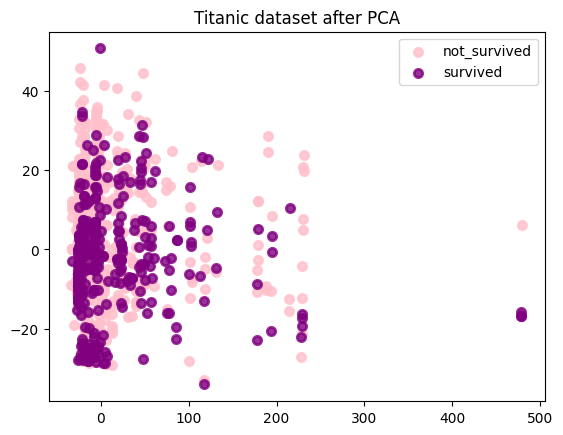

Watch out! There is an intersection between classes, the model won't work as expected!


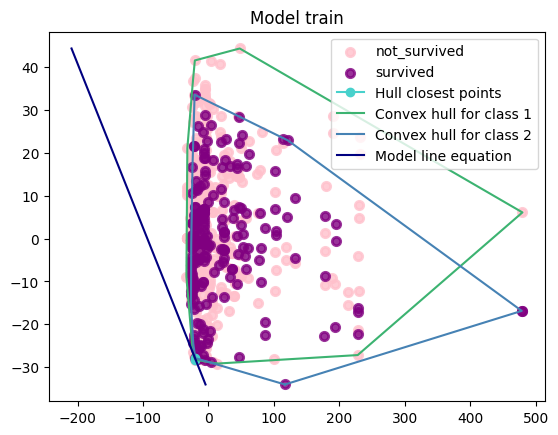

Acurácia: 0.2926208651399491
Precisão: 0.32122398381940365
Revocação: 0.2926208651399491
F1: 0.13803395962373724


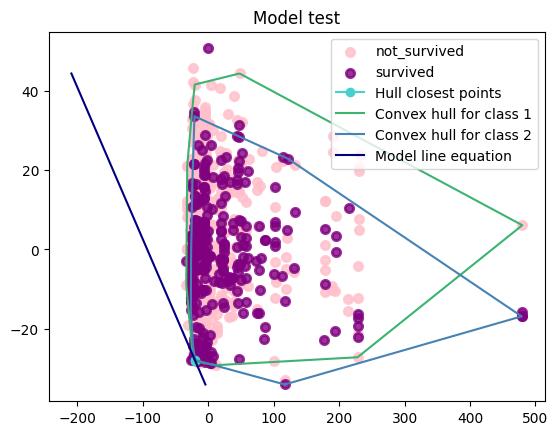

In [40]:
import pandas as pd
titanic = pd.read_csv('https://raw.githubusercontent.com/Bernardonasc/Geometria-Computacional/main/datasets/titanic.csv')
titanic = titanic.dropna()
titanic = titanic.drop(['zero','Passengerid','Parch','zero.1','zero.2','zero.3','zero.4','zero.5','zero.6','zero.7','zero.8','zero.9','zero.10','zero.11','zero.12','zero.13','zero.14','zero.15','zero.16','zero.17','zero.18'], axis=1)
titanic.rename(columns={'2urvived': 'Survived'}, inplace=True) # fazendo limpeza de campos inuteis

y = titanic.Survived

pca = PCA(n_components=2)
X = titanic.drop('Survived', axis=1)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

# definindo as duas classes
class_names = ['not_survived', 'survived']
class_numbers = [0,1]

#plotando vizualização do conjunto de dados no geral
plot_dataset_points(X, y, class_numbers, class_names, 'Titanic dataset after PCA', colors=['pink', 'purple'])

#selecionando as classes class_0 e class_1

mask = (y == class_numbers[0]) | (y == class_numbers[1])
X_selected = X[mask]
y_selected = y[mask]

#dividindo o conjunto de dados em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

#treinando o modelo
try:
  model_fit(X_train, y_train, class_numbers)
except Exception as err:
  print(err)
#modelo gerado com dados de treino
plot_dataset_points_and_model_hull(X_train, y_train, class_numbers, class_names, "Model train", colors=['pink', 'purple'])

#avaliando o modelo
y_pred = model_predict(X_test, class_numbers)
evaluate_metrics(y_test, y_pred)

#desempenho do modelo lebando em conta treino e teste
plot_dataset_points_and_model_hull(X_selected, y_selected, class_numbers, class_names, "Model test", colors=['pink', 'purple'])
